# Practical 3: Variational supervised learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In this practical you will learn how to implement supervised variational deep learning methods. The starting point is a multi-class logistic regression on the MNIST dataset.

The forward model is just the linear equation
$$
f(x) = W x
$$
where $W$ is a (number of input pixels)x(number of classes) matrix.
The forward model defines the class probabilities through a softmax transformation, which make the output positive and normalized:
$$
p(y_n = j \mid x_n, W) = \frac{e^{f_j(x)}}{\sum_{k=1}^J e^{f_j(x)}}
$$
This results in the usual softmax cross-entropy negative log likelihood loss. Since we want to approximate the Bayesian posterior, we need to specify a prior over the weights. The simplest choice is a uncorrelated normal distribution:
$$
p(W) = \prod_{j,k} p(W_{jk}) = \prod_{j,k} \mathcal{N}(W_{jk} \mid 0, \nu^2)~.
$$
In order to approximate the posterior, we also need to specify a parameterized variational distribution. The simplest choice is to use another parameterized uncorrelated normal distribution:
$$
q(W; M, S) = \prod_{j,k} q(W_{jk}; M_{jk}, S_{jk}) = \prod_{j,k}\mathcal{N}(W_{jk} \mid M_{jk}, S_{jk}^2)~.
$$
where $M$ and $S$ are arrays of learnable variational parameters. Note that we are assuming that the parameters are uncorrelated under the posterior distribution. This approximation is known as mean-field for historical reasons due to its origin in the analysis of the physics of magnets. As we saw in the lecture, we can train these parameters by minimizing the negative ELBO:
$$
\mathcal{L}(\mu^{(q)}, \sigma^{(q)}) = - \mathbb{E}_{W \sim q(W; M, S)}\left[\log{\frac{\left(\prod_{n=1}^N p(y_n \mid x_n, W) \right) \prod_{j,k} \mathcal{N}(W_{jk} \mid 0, \nu^2)}{\prod_{j,k}\mathcal{N}(W_{jk} \mid M_{jk}, S_{jk}^2)}}\right]
$$
Since we cannot evaluate the loss exactly, we use an unbiased gradient estimator using the reparameterization trick:
$$
\mathcal{L}(\mu^{(q)}, \sigma^{(q)}) \approx -\frac{1}{L} \sum_{m=1}^L \left(\log{\frac{\left(\prod_{n=1}^N p(y_n \mid x_n, M_{jk} + S_{jk} \epsilon^{(m)}_{jk}) \right) \prod_{j,k} \mathcal{N}(M_{jk} + S_{jk} \epsilon^{(m)}_{jk} \mid 0, \nu^2)}{\prod_{j,k}\mathcal{N}(M_{jk} + S_{jk} \epsilon^{(m)}_{jk} \mid M_{jk}, S_{jk}^2)}}\right)
$$
where $E_m$ is a matrix of random numbers sampled from uncorrelated standard normal distributions, a random number for each of the weights (remember, we have a posterior distribution for each entry of the forward model weight matrix).

We are now ready to implement this in pytorch! If you are already familiar with Pytorch, most of the following code will be familiar to you. The only difficulty is that we need to perform some re-shaping gymnastic in order to perform batched operations where both the weights and the input have a batch dimension.
This is required since a batch of weights need to be sampled from the variational posterior at every step in order to compute the Monte Carlo gradient estimator.

We start by defining the variational logistic regression class. Be sure toi study the code (including the comments) in details!

In [6]:
class VariationalLogisticRegression(nn.Module):

  def __init__(self, dim_data, num_classes, prior_scale):
    super(VariationalLogisticRegression, self).__init__()

    self.dim_data = dim_data
    self.num_classes = num_classes

    #Prior
    self.prior = torch.distributions.normal.Normal(loc = torch.zeros(num_classes, dim_data), 
                                                   scale = prior_scale*torch.ones(num_classes, dim_data))
    
    #Log likelihood loss
    self.loss = torch.nn.CrossEntropyLoss(reduction='none')

    self.mu_W1 = nn.Parameter()
    
    # Variational parameters
    self.mu_W2 = nn.Parameter(torch.zeros(num_classes, dim_data)) #Mean
    self.s_W2 = nn.Parameter(torch.zeros(num_classes, dim_data)) #Scale

  def get_weights_samples(self, num_samples): 
    # This time I will implement the reparameterization manually tp show you how it works
    epsilon_dist = torch.distributions.normal.Normal(loc = torch.zeros(self.num_classes, self.dim_data), 
                                                     scale = torch.ones(self.num_classes, self.dim_data))
    epsilon = epsilon_dist.sample((num_samples,)) #We do not need to use rsample as we reparameterized manually
    return self.mu_W2 + F.softplus(self.s_W2)*epsilon #This is the reparametrization formula
    #The final sample is a 3D tensor where the first dim is the batch dimension over the samples 
    #from the posterior. Note that this is different from the mini-batching of the dataset 
    #in regular deep learning. 

  def evaluate_log_prior(self, weights_samples):
    return torch.mean(self.prior.log_prob(weights_samples))

  def evaluate_log_q(self, weights_samples):
    q_dist = torch.distributions.normal.Normal(self.mu_W2, 
                                               F.softplus(self.s_W2))
    return torch.mean(q_dist.log_prob(weights_samples))

  def compute_predictions(self, weights_samples, features):
    #We need to apply a linear layer. However this is slighly different from the usual case 
    #since we have two kinds of batch dimensions. We have a (frequentist) batch over data
    #and a (Bayesian) batch over the parameters. Our prediction (output of the netwirk) should
    # therefore have two batch dimensions: we have one prediction for each datapoint and
    #for each sampled weights. We therefore want the output to be (data_batch, param_batch, num_classes).

    #The is the only inplementational annoyance of variational deep learning in pytorch since
    #the usual layes do not allow for this sort of double batching. However, it is usually easy to
    #adapt them to our needs. In the case of linear layers, it is better to directly use the 
    #matmul (matrix multiplication) function since it also work with a batch of weights.
    #However, in order to simulaneously have the frequentist batch dimension we need to permute
    #the axis of the features from (batch_size, num_features) to (num_features, batch_size).
    #This works because matrix multiplication AB acts in parallel (i.e. as a batch) along the second dimension 
    #of the matrix B! 
    pre_softmax_preds = torch.matmul(weights_samples.unsqueeze(0), features.unsqueeze(1).unsqueeze(3)).squeeze()
    #Of course we could have done the same with a loop. However, that would be extremely inefficient in Python!
    return pre_softmax_preds

  def evaluate_log_likelihood(self, weights_samples, features, labels):
    #We start by computing the prediction for each datapoint and weight sample
    pre_softmax_preds = self.compute_predictions(weights_samples, features)

    #We can now call the loss function. Note however that we need to reshape the
    #output of the model since the pre-implement loss expect a single batch dimension.
    #Also note that the loss needs to be summed over the data batch 
    #and averaged over the variational sample batch. We also need to repeat the target accordingly.
    data_batch, param_batch, num_classes = pre_softmax_preds.shape
    repeated_labels = torch.cat([y.repeat((param_batch,)) for y in labels])
    log_lk_loss = self.loss(pre_softmax_preds.reshape((data_batch*param_batch, num_classes)), 
                            repeated_labels)
    log_lk_loss = -log_lk_loss.reshape((data_batch, param_batch))
    return torch.mean(torch.sum(log_lk_loss,0))

  def evaluate_ELBO(self, features, labels , num_samples):
    weights = self.get_weights_samples(num_samples)
    avg_log_lk = self.evaluate_log_likelihood(weights, features, labels)
    # log_prior = self.evaluate_log_prior(weights)
    # log_q = self.evaluate_log_q(weights)
    q = torch.distributions.normal.Normal(self.mu_W2, F.softplus(self.s_W2))
    # return avg_log_lk + log_prior - log_q
    return avg_log_lk + torch.mean(torch.distributions.kl.kl_divergence(self.prior, q))
    

  def compute_marginalized_predictions(self, features, num_samples):
    weights = self.get_weights_samples(num_samples)
    pre_softmax_preds = self.compute_predictions(weights, features)
    preds = nn.Softmax(dim=2)(pre_softmax_preds)
    return torch.mean(preds,1)


Now that the hard work is done, we can load the MNIST data.

In [3]:
from torchvision import datasets, transforms

# load and preprocess MNIST data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST(root='./data',download=True, train=True, transform=transform)
testset = datasets.MNIST(root='./data', download=True, transform=transform)

# Prepare the training set
train_features = torch.cat([data[0].view((1,28*28)) for data in trainset])
train_labels = torch.Tensor([data[1] for data in trainset]).type(torch.long)

We are mostly interested in the low data regime, we will therefore train the variational model with using only $20$ labeled images.

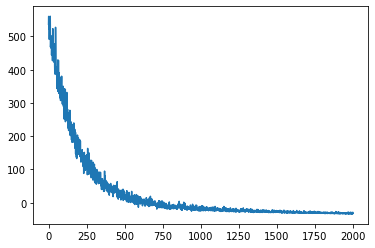

In [4]:
# Extract a small sub-training set
D = 20
sub_train_features = train_features[:D,:]
sub_train_labels = train_labels[:D]

# Set model and optimizer
variational_network = VariationalLogisticRegression(dim_data=28*28, num_classes=10,prior_scale=5.)
optimizer = optim.Adam(variational_network.parameters(), lr=0.001)

# Variational training loop
num_iters = 2000
num_samples = 25

loss_list = []
for iter in range(num_iters):

  # zero the parameter gradients
  optimizer.zero_grad()

  # forward + backward + optimize
  loss = -variational_network.evaluate_ELBO(features=sub_train_features, 
                                            labels=sub_train_labels, 
                                            num_samples=num_samples)
  loss.backward()
  optimizer.step()

  loss_list.append(float(loss.detach().numpy()))

plt.plot(loss_list)
plt.show()

We can finally compute the accuracy of the predictions on the test set:

In [5]:
test_N = 100
val_N = 60000 - test_N
test_set, val_set = torch.utils.data.random_split(testset, [test_N, val_N])


# Prepare test set
test_features = torch.cat([data[0].view((1,28*28)) for data in test_set])
test_labels = torch.Tensor([data[1] for data in test_set]).type(torch.long)

preds = variational_network.compute_marginalized_predictions(test_features, num_samples=100)

print("accuracy:", np.sum(np.array(torch.argmax(preds,1) == test_labels))/test_labels.shape[0])

accuracy: 0.61


## Exercise 1
In the previous code, we are computing the gradient estimator of the whole using the reparameterization trick. This is a bit unefficient as the KL divergence between variational distribution and prior can be computed in closed form. 
Re-implement the loss by separateing the average log-likelihood, which can be estimated using the reparameterization trick, and the the closed KL divergence between prior and variational posterior. You can either implement the formula directly or use the existing pytorch implementation for the KL. 
Compare the speed of convergence. 


## Interlude: Using mini-batches in variational inference

So far we computed the gradient using all available images of the training set. However, when the training set is large, it is necessary to use Monte Carlo estimates of the gradient where the data is sub-sampled. In that case, we need to re-weight the contribution of the likelihood in order to preserve its relative contriobution compared to the prior:

$$
\log{p(y_{1:N} \mid x_{1:N})} = \sum_{n=1}^N \log{p(y_n \mid x_n)} \approx \frac{N}{M} \sum_{y_b \in \text{Minibatch}} \log{p(y_b \mid x_b)}
$$

where $M$ is the number of images in the mini-batch. This adjustment is not important in regular deep learning because the log-likelihood is the only component of the loss and scaling total loss does not affect the direction of the gradient update. On the other hand, the ELBO is a balance of three different terms whose relative scale determines the shape of the target posterior. Using mini-bacthes without correction would "let the network think" to have less data than it is actually available. This lead to an over-estimation of the uncertainty.

## Exercise 2
Implement the code for mini-batching correction. Train the variational logistic regression on the whole MNIST training set using mini-batches of $50$ images. 

## Exercise 3
Implement a fully connected variational two-layers network with 50 hidden units and ReLu activations. Compare variational and maximum likelihood results in terms of accuracy and error calibration. Compare with logistic regression in a small data regime ($15$ datapoints) and large data regime ($500$ datapoints). 

## Exercise 4: Bonus exercise for ambitious students
Implement a variational convolutional neural network. You need to find a way to batch the convolutional operation with respect to the sampled weights. (Hint: you can reshape the weight batch dimension into the output channel dimension use the "groups=num_samples" as input to the convolutional layers). If you are less ambitious, you can also decide to use n=1 gradient estimators so to avoid the problem altpogether. Comapre accuracy and calibration with the fully connected network and logistic regression.